In [1]:
from langchain import OpenAI
from langchain.agents import AgentType, initialize_agent
from langchain.agents import Tool, tool
from langchain import agents
import langchain
import os
import requests
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import sys


from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFLoader
from langchain_openai import ChatOpenAI

from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
Embedding_model = 'text-embedding-ada-002' 

from langchain.text_splitter import CharacterTextSplitter


In [92]:
## This model based on this paper: https://pubs.acs.org/doi/abs/10.1021/acs.jpcb.1c05264
## And is coming from this URL 
## https://github.com/zavalab/ML/blob/master/CMC_GCN/saved_models/gnn_logs_save_202_hu256_lr0.005_best_trainalles_seed4592/ep200bs5lr0.005hu256es.pth.tar

# !pip install dgllife
# !pip install  dgl -f https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl.nn.pytorch import GraphConv
from rdkit import Chem
from dgllife.utils import CanonicalAtomFeaturizer, mol_to_bigraph, BaseAtomFeaturizer, atomic_number

# Define the GCNReg model as per the repository's implementation
class GCNReg(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes, saliency=False):
        super(GCNReg, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify1 = nn.Linear(hidden_dim, hidden_dim)
        self.classify2 = nn.Linear(hidden_dim, hidden_dim)
        self.classify3 = nn.Linear(hidden_dim, n_classes)
        self.saliency = saliency

    def forward(self, g):
        h = g.ndata['h']
        if self.saliency:
            h.requires_grad = True
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        x = F.relu(self.classify1(hg))
        x = F.relu(self.classify2(x))
        x = self.classify3(x)
        return x

from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer

def get_graph_from_smiles(smiles):
    graph = smiles_to_bigraph(smiles, node_featurizer=CanonicalAtomFeaturizer())
    return graph

def collate(samples):
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

def predict_single_point(smiles, model_path, device):
    # Load the model
    model = GCNReg(in_dim=74, hidden_dim=256, n_classes=1)  # Adjust input and hidden dimensions as needed
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Prepare the input
    graph = get_graph_from_smiles(smiles)
    graph = graph.to(device)
    graph.ndata['h'] = graph.ndata['h'].to(device)

    # Perform prediction
    with torch.no_grad():
        output = model(graph)
    
    return output.cpu().item()

model_path = r"../GNN/ep200bs5lr0.005hu256es.pth.tar"  # Path to the model checkpoint
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# initial_surfactant = 'CCCCCCCCCCCCOCCOCCO'
# prediction = predict_single_point(initial_surfactant, model_path, device)
# prediction

@tool
def predict_cmc(smiles):
    '''
    This tool predicts the log Critical Micelle Concentration (CMC) for a SMILES.
    '''
    model_path = r"../surrogates/CMC/ep200bs5lr0.005hu256es.pth.tar"  # Path to the model checkpoint
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    try:
        infered_cmc = predict_single_point(smiles, model_path, device)
    except:
        infered_cmc = None
    return np.round(infered_cmc,3)

predict_cmc('CCCCCOCCO')

3.716

In [94]:
from langchain.memory import ConversationBufferMemory

RetrievalQA_prompt = """What are the design guidelines for making the surfactant with a Critical Micelle Concentration? 
    This can be based on making changes to the functional groups or other changes to the molecule. Summarize answer"""
def RetrievalQABypassTokenLimit(vector_store, RetrievalQA_prompt, llm, k=10, fetch_k=50, min_k=4, chain_type="stuff"):
    while k >= min_k:
            try:
                retriever = vector_store.as_retriever(
                    search_type="mmr",
                    search_kwargs={"k": k, "fetch_k": fetch_k},
                )
                qa_chain = RetrievalQA.from_chain_type(
                    llm=llm,
                    chain_type=chain_type,
                    retriever=retriever,
                    memory=ConversationBufferMemory(
                            ))
                
                # Check to see if we hit the token limit
                result = qa_chain.run({"query": RetrievalQA_prompt})
                return result  # If successful, return the result and exit the function
    
            except Exception as e:
                # If an error is caught, reduce the value of k and retry
                # print(e)
                print(
                    f"\nk={k} results hitting the token limit for the chosen LLM. Reducing k and retrying...\n"
                )
                k -= 1

@tool
def lookup_papers(prompt):
    '''This tool looks up design guidelines for molecules with lower Critical Micelle Concentration by looking through research papers.
    '''
    guide_lines = []
    for m in range(2):
        text_splitter = CharacterTextSplitter(
            chunk_size=500, chunk_overlap=20)
        paper_file =f'../data/papers/CMC/{m}.pdf'
        pages = PyPDFLoader(paper_file).load_and_split()
        sliced_pages = text_splitter.split_documents(pages)
        faiss_vectorstore = FAISS.from_documents(sliced_pages, OpenAIEmbeddings(model=Embedding_model))
        
        llm=ChatOpenAI(
                        model_name='gpt-4o',
                        temperature=0.1,
                        )
        g = RetrievalQABypassTokenLimit(faiss_vectorstore, RetrievalQA_prompt, llm)
        guide_lines.append(g)
        # break
    return guide_lines

# guidel_lines = lookup_papers("")
# guidel_lines

In [95]:

@tool
def check_validity(SMILES):
    '''This tool inputs SMILES string representations checks if it is a chemically feasible molecule.
    '''
    from rdkit import Chem
    from rdkit.Chem import Draw
    try:
        mol = Chem.MolFromSmiles(SMILES)
        if mol is None:
            return "Invalid", SMILES
        return "Valid", SMILES
    except Exception as e:
        # return f"An error occurred: {str(e)}"
        return "Invalid", SMILES

tools = [lookup_papers, check_validity, predict_cmc]

In [96]:
# prompt= ""
# lookup_papers(prompt)

In [97]:
from langchain.agents.structured_chat.base import StructuredChatAgent
from langchain.agents.agent import AgentExecutor
from langchain.agents import AgentType
from langchain.schema import HumanMessage, SystemMessage
from langchain.agents import AgentExecutor, create_openai_functions_agent

message = """You are a helpful Chemist AI assistant. You are tasked to make changes to a molecule and reduce its Critical Micelle Concentration
    Use the tools to get chemical intution and if you don't know, do not make up answers. 
    """

system_message = SystemMessage(
  content=message
)

agent_llm = ChatOpenAI(
                        model_name='gpt-4o',
                        temperature=0.1,
                        max_tokens=4096
                        )

from langchain.agents import initialize_agent
from langchain.memory import ConversationBufferMemory
agent = initialize_agent(
            tools=tools, llm=agent_llm, agent=AgentType.CONVERSATIONAL_REACT_DESCRIPTION,
            verbose=True, memory=ConversationBufferMemory(memory_key="chat_history", input_key='input', output_key="output", return_messages=True),
            early_stopping_method='generate', handle_parsing_errors=True, system_message=system_message, prefix=message,
            agent_kwargs = {
                "prefix":message,
        "system_message": system_message,
    }, return_intermediate_steps=True, max_iterations=40
            )



In [83]:
# response = agent_executor.invoke({"input": f"Look up design guidelines and make changes to the MOF [Co].[O-]C(=O)c1ccncc1 so it will have a higher band gap:\
#             After each change you should first check validity of new SMILES, if valid evaluate the band gap, otherwise revert change and try something else.\n\
#             "})

In [98]:
initial_surfactant = "CCCCCOCCO" 
question = f"Look up design guidelines and make changes to {initial_surfactant} so it will have a lower Critical Micelle Concentration (CMC):\
            Alway evaluate the CMC and then validity of the input SMILES first\
             After each change you should calculate the logCMC predicted value and evaluate the the validity of the new molecule. \
            if invalid revert change to the previous valid SMILES and try something else and re-evauate validity.\
            Do not make changes involving Fluorine.\
             Iterate for 10 new molecule candidates and then stop.\n\
             "
iteration_data = []
iteration = 0
cost = 0
from langchain_community.callbacks import get_openai_callback


for step in agent.iter({"input": question}):
    with get_openai_callback() as cb:
        if output := step.get("intermediate_step"):
            action, value = output[0]
            if action.tool == "predict_cmc":
                infered_cmc = value
            if action.tool == "check_validity":
                chemical_feasibility, SMILES = value
                iteration_data.append({
                                        'iteration': iteration,
                                        'data': {
                                            'SMILES': SMILES,
                                            'Chemical Feasibility': chemical_feasibility,
                                            'CMC': infered_cmc,
                                        }
                                    })
                iteration += 1
                # break 
                # assert is_prime(int(value))
            # Ask user if they want to continue
            # _continue = input("Should the agent continue (Y/n)?:\n") or "Y"
            # if _continue.lower() != "y":
            #     break
    cost += cb.total_cost

print(f'Cost: ${cost}')



> Entering new AgentExecutor chain...
Thought: To begin, I need to look up design guidelines for molecules with lower Critical Micelle Concentration (CMC).

Action: lookup_papers
Action Input: design guidelines for molecules with lower Critical Micelle Concentration (CMC)
Observation: ['Designing surfactants with a specific Critical Micelle Concentration (cmc) involves manipulating the molecular structure, particularly the hydrophobic tail and the hydrophilic headgroup. Here are the key guidelines:\n\n1. **Hydrophobic Tail Length and Structure**:\n   - **Chain Length**: Increasing the length of the hydrophobic tail generally decreases the cmc because longer tails enhance hydrophobic interactions, promoting micelle formation.\n   - **Branching**: Introducing branching in the hydrophobic tail can increase the cmc due to a reduction in effective tail length and increased steric hindrance, which can disrupt micelle formation.\n\n2. **Hydrophilic Headgroup**:\n   - **Type and Size**: The 

In [85]:
print(cb.total_cost)

0.0


In [86]:
iteration_data

[{'iteration': 0,
  'data': {'SMILES': 'CCCCCCCOCCO',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.497}},
 {'iteration': 1,
  'data': {'SMILES': 'CCCCCCCCOCCO',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.173}},
 {'iteration': 2,
  'data': {'SMILES': 'CCCCCCCCCOCCO',
   'Chemical Feasibility': 'Valid',
   'CMC': 2.746}},
 {'iteration': 3,
  'data': {'SMILES': 'CCCCCCCCCCOCCO',
   'Chemical Feasibility': 'Valid',
   'CMC': 1.999}},
 {'iteration': 4,
  'data': {'SMILES': 'CCCCCCCCCCCOCCO',
   'Chemical Feasibility': 'Valid',
   'CMC': 1.198}},
 {'iteration': 5,
  'data': {'SMILES': 'CCCCCCCCCCCCOCCO',
   'Chemical Feasibility': 'Valid',
   'CMC': 0.861}},
 {'iteration': 6,
  'data': {'SMILES': 'CCCCCCCCCCCCCOCCO',
   'Chemical Feasibility': 'Valid',
   'CMC': 0.78}},
 {'iteration': 7,
  'data': {'SMILES': 'CCCCCCCCCCCCCC(OCCO)',
   'Chemical Feasibility': 'Valid',
   'CMC': 0.429}},
 {'iteration': 8,
  'data': {'SMILES': 'CCCCCCCCCCCCCCCOCCO',
   'Chemical Feasibility': 'Valid',
 

In [100]:
import json
json_data = json.dumps(iteration_data, indent=4)
# Save the JSON data to a file
with open(f"../results/CMC/{iteration_data[0]['data']['SMILES']}_guided.json", "w") as json_file:
    json_file.write(json_data)

Text(0, 0.5, 'logCMC (μM)')

<Figure size 2560x1920 with 0 Axes>

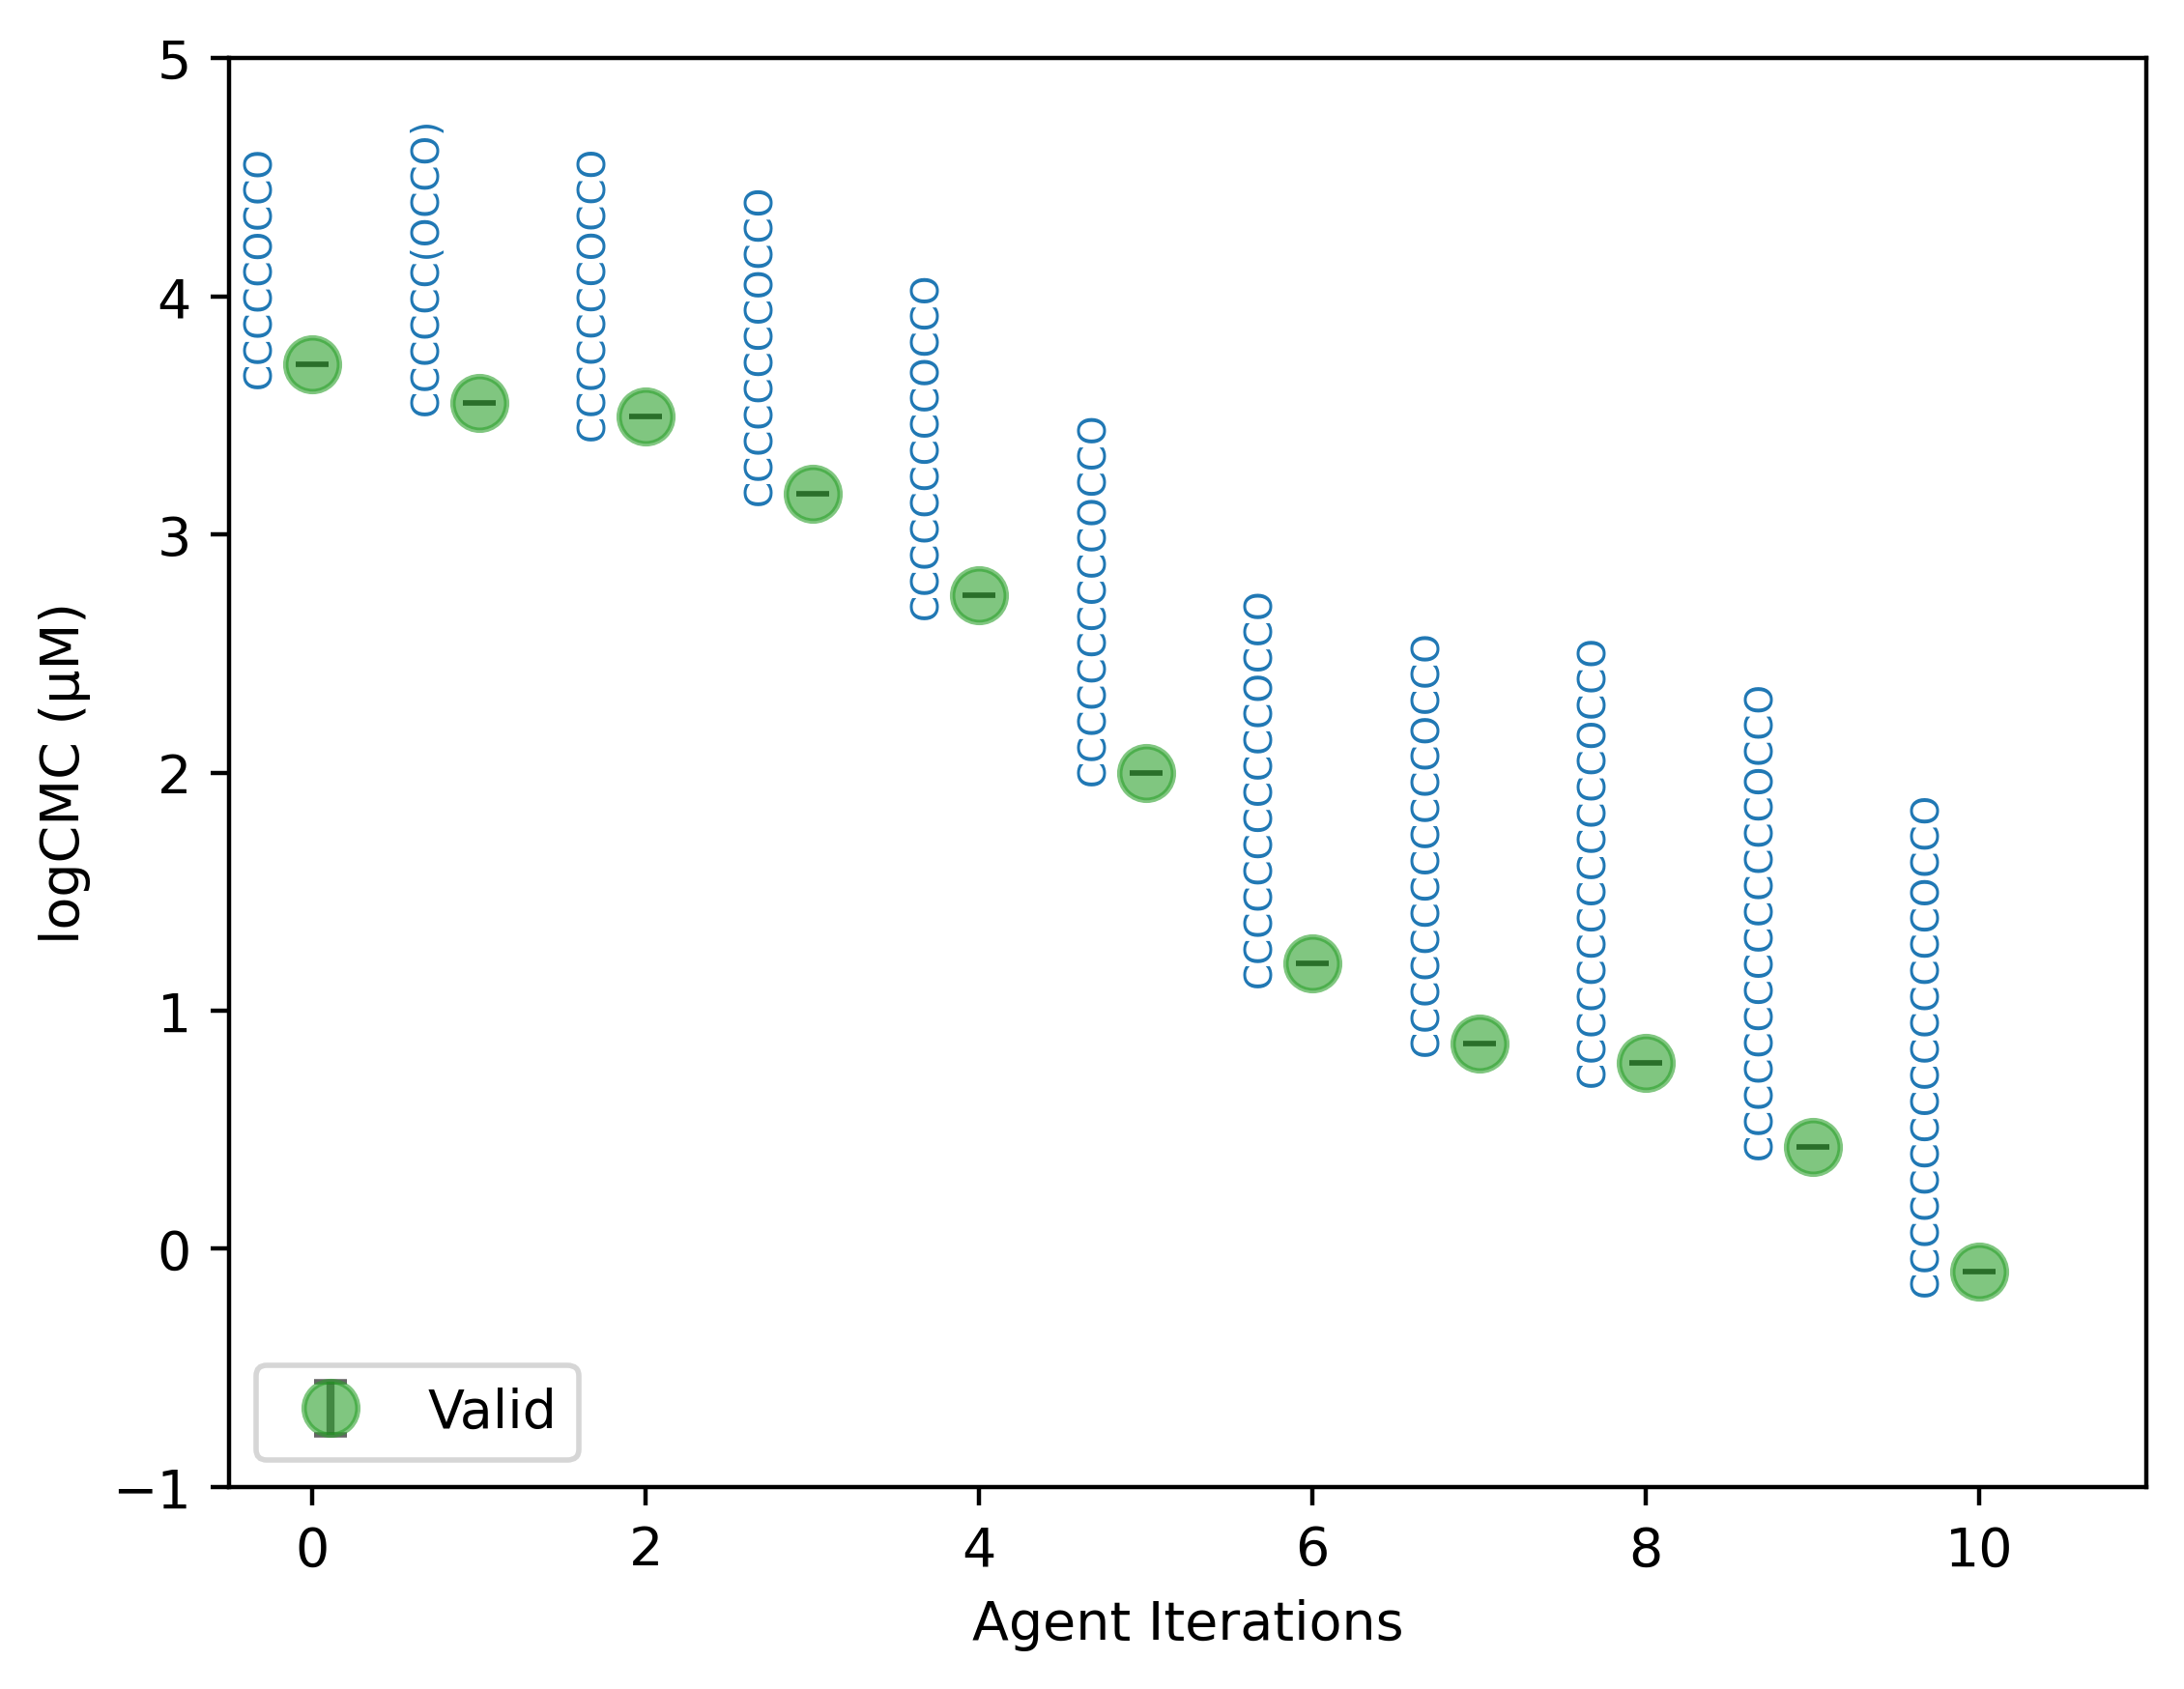

In [104]:
import matplotlib.pyplot as plt

iterations = [item['iteration'] for item in iteration_data]
mean_cmcs = [item['data']['CMC'] for item in iteration_data]
# std_band_gaps = [item['data']['STD CMC'] for item in iteration_data]
smiles_labels = [item['data']['SMILES'] for item in iteration_data]
chemical_feasibilities = [item['data']['Chemical Feasibility'] for item in iteration_data]

plt.figure(dpi=400)

colors = ['C2' if feas == 'Valid' else 'C0' for feas in chemical_feasibilities]

# Plot with error bars and color-coded points
plt.figure(dpi=400)
for i, (x, y, yerr, color) in enumerate(zip(iterations, mean_cmcs, np.zeros(len(mean_cmcs)), colors)):
    plt.errorbar(x, y, yerr=yerr, fmt='o', color=color, ecolor='k', capsize=3,
                 linestyle='None', alpha=0.6, markersize=10, label=chemical_feasibilities[i])



vertical_offsets = [(-10 + 5 * (i % 2)) for i in range(len(iterations))]  # Alternating vertical offsets

for x, y, label, offset in zip(iterations, mean_cmcs, smiles_labels, vertical_offsets):
    plt.text(x-0.2, y + offset/100, label, verticalalignment='bottom', horizontalalignment='right', fontsize=7, color='C0', rotation=90)

ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.legend(by_label.values(), by_label.keys(), loc="lower left")

plt.xlabel('Agent Iterations')
plt.xlim([-0.5,11])
plt.ylim([-1, 5])
plt.ylabel('logCMC (μM)')

# plt.savefig(f"../results/{iteration_data[0]['data']['SMILES']}_guided.png")

<Figure size 2560x1920 with 0 Axes>

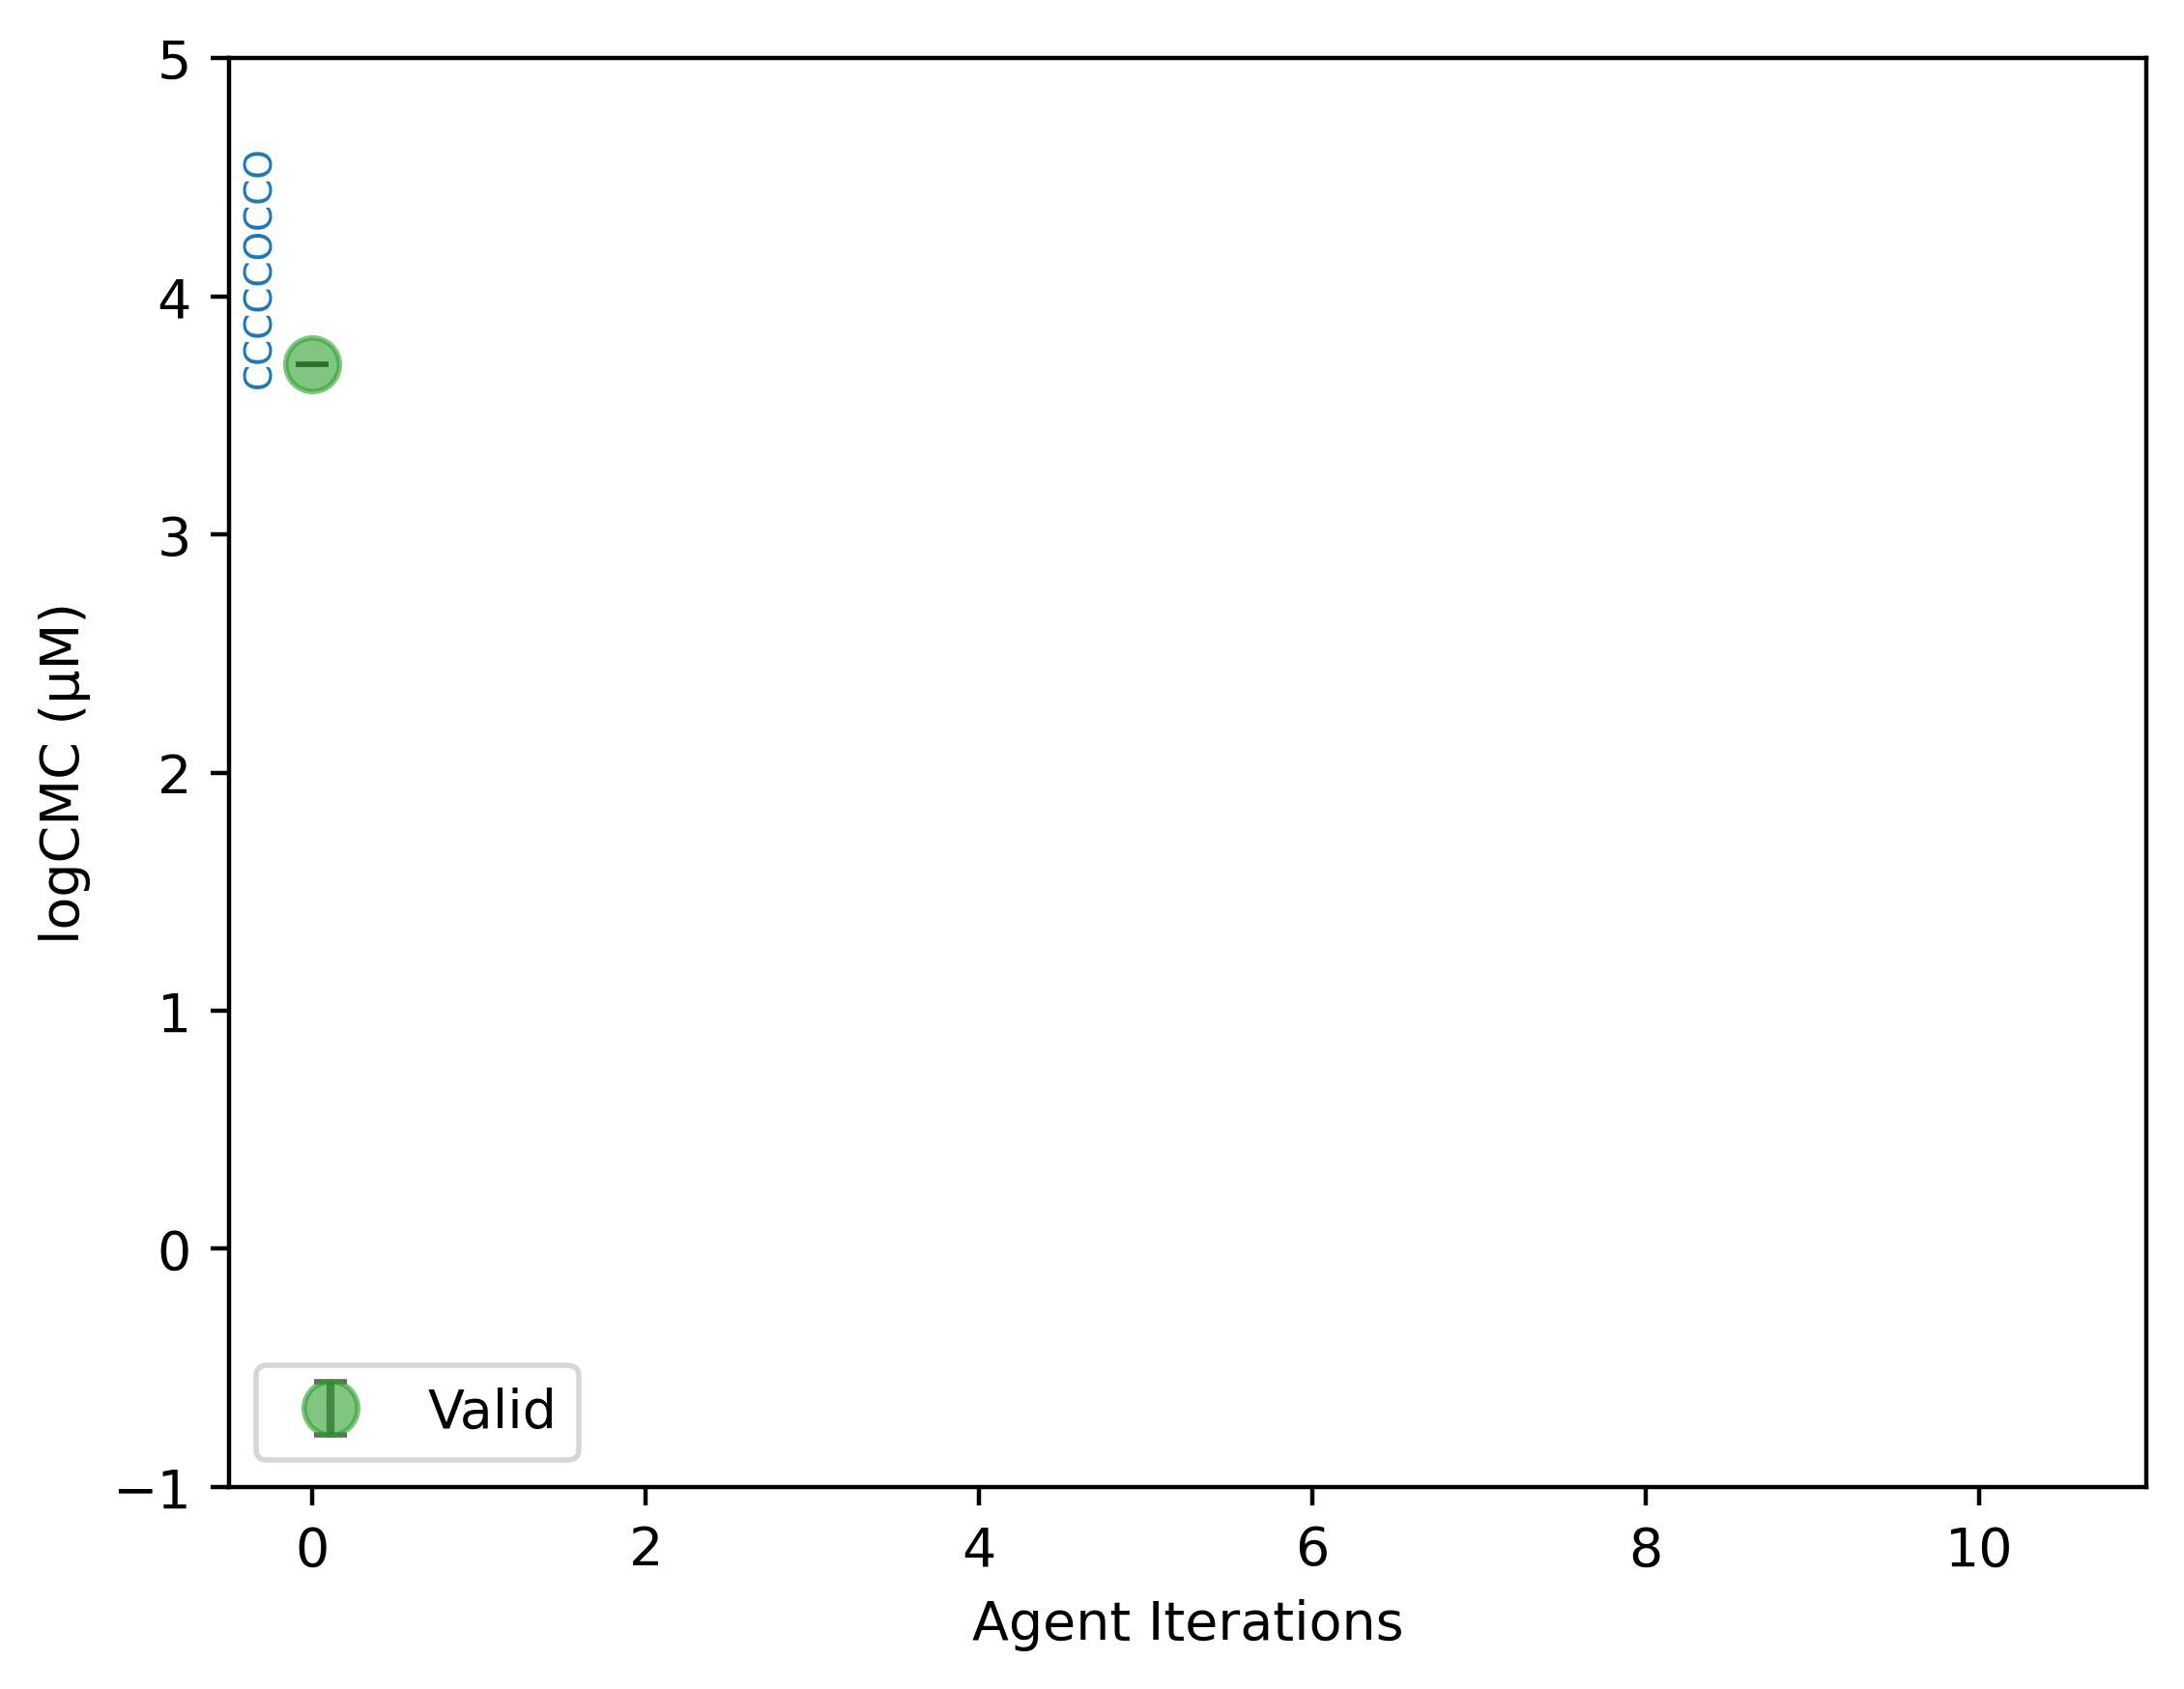

In [162]:
## Plotting sequntially for presentation purposes

from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt



from rdkit.Chem import Draw
from PIL import Image

def visualize_smiles(smiles, filename):
    # Convert SMILES to molecule
    mol = Chem.MolFromSmiles(smiles)
    
    # Generate image of the molecule with RDKit and a transparent background
    img = Draw.MolToImage(mol, size=(1000, 1000), kekulize=True, wedgeBonds=True, options=Draw.DrawingOptions())
    
    # Convert the image to have a transparent background
    img = img.convert("RGBA")
    datas = img.getdata()
    newData = []
    for item in datas:
        # Change all white (also shades of whites)
        # to transparent
        if item[0] > 200 and item[1] > 200 and item[2] > 200:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    img.putdata(newData)
    
    # Save the image
    img.save(filename, "PNG")


import json


with open(f"../results/CMC/{initial_surfactant}_guided.json", "r") as json_file:
    iteration_data = json.load(json_file)

iterations = [item['iteration'] for item in iteration_data]
mean_cmcs = [item['data']['CMC'] for item in iteration_data]
std_cmcs = np.zeros(len(mean_cmcs))
smiles_labels = [item['data']['SMILES'] for item in iteration_data]
chemical_feasibilities = [item['data']['Chemical Feasibility'] for item in iteration_data]

plt.figure(dpi=400)

colors = ['C2' if feas == 'Valid' else 'C0' for feas in chemical_feasibilities]

# Plot with error bars and color-coded points

iter = 0

plt.figure(dpi=400)
for i, (x, y, yerr, color) in enumerate(zip(iterations, mean_cmcs, np.zeros(len(mean_cmcs)), colors)):
    plt.errorbar(x, y, yerr=yerr, fmt='o', color=color, ecolor='k', capsize=3,
                 linestyle='None', alpha=0.6, markersize=10, label=chemical_feasibilities[i])

    filename = f'../results/CMC/iter_{i}_{smiles_labels[i]}.png'
    visualize_smiles(smiles_labels[i], filename)
    if i == iter:
        break


vertical_offsets = [(-10 + 5 * (k % 2)) for k in range(len(iterations))]  # Alternating vertical offsets

for i, (x, y, label, offset) in enumerate(zip(iterations, mean_cmcs, smiles_labels, vertical_offsets)):
    plt.text(x-0.2, y + offset/100, label, verticalalignment='bottom', horizontalalignment='right', fontsize=7, color='C0', rotation=90)
    if i == iter:
        break

ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.legend(by_label.values(), by_label.keys(), loc="lower left")

plt.xlabel('Agent Iterations')
plt.xlim([-0.5,11])
plt.ylim([-1, 5])
plt.ylabel('logCMC (μM)')

plt.savefig(f"../results/CMC/{iter}_{smiles_labels[iter]}_guided.png")

In [125]:
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt



from rdkit.Chem import Draw
from PIL import Image

def visualize_smiles(smiles, filename):
    # Convert SMILES to molecule
    mol = Chem.MolFromSmiles(smiles)
    
    # Generate image of the molecule with RDKit and a transparent background
    img = Draw.MolToImage(mol, size=(1000, 1000), kekulize=True, wedgeBonds=True, options=Draw.DrawingOptions())
    
    # Convert the image to have a transparent background
    img = img.convert("RGBA")
    datas = img.getdata()
    newData = []
    for item in datas:
        # Change all white (also shades of whites)
        # to transparent
        if item[0] > 200 and item[1] > 200 and item[2] > 200:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    img.putdata(newData)
    
    # Save the image
    img.save(filename, "PNG")

# Example usage
filename = f'{initial_surfactant}.png'
visualize_smiles(initial_surfactant, filename)

In [13]:
# results = agent.invoke(input=f"Look up design guidelines and make changes to the MOF [Co].[O-]C(=O)c1ccncc1 so it will have a higher band gap:\
#             After each change you should first check validity of new SMILES, if valid evaluate the band gap, otherwise revert change and try something else. Do 5 iterations.\n\
#             ")